In [27]:
%matplotlib inline
#from preamble import *
import numpy as np
import math
import pandas as pd
import pickle
import sys
from collections import Counter
from tqdm import tqdm_notebook
from sklearn.metrics import classification_report
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib.pyplot as plt

In [28]:
import seaborn as sns

sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

In [29]:
import torch
import torch.optim as optim
import torch.nn as nn
import datetime
import helper
import ANN

In [30]:
helper = helper.Helper()
net = ANN.ANN()

In [31]:
fname = 'data/prediction_data.csv'
data = pd.read_csv(fname)
#data = data[(data['Season'] < 1819)]
#data = data[(data['League'] != 'BUNDES') & (data['Season'] < 1819)]
data = data[(data['League'] != 'BUNDES') & (data['League'] != 'LALIGA') & (data['Season'] < 1819)]

In [32]:
def transformResult(row):
    if(row['Result'] == 'H'):
        return 0
    elif(row['Result'] == 'A'):
        return 2
    else:
        return 1

In [33]:
from sklearn.preprocessing import MinMaxScaler

data["Result"] = data.apply(lambda row: transformResult(row),axis=1)

X_train = data[data['Season'] < 1718].reset_index(drop=True)
X_test = data[data['Season'] == 1718].reset_index(drop=True)

Y_train = X_train['Result']
Y_test = X_test['Result']
X_train = X_train.iloc[:, 9:]
X_test = X_test.iloc[:, 9:]

In [34]:
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [35]:
def getaccu(row):
    if(row['Result'] == row['Predict']):
        return 'O'
    else:
        return 'X'
def transformResult2(row, feature):
    if(row[feature] == 0):
        return 'H'
    elif(row[feature] == 2):
        return 'A'
    else:
        return 'D'

In [36]:
X_test_ = helper.Convert_to_tensor(X_test, 'X')

In [37]:
net.load_state_dict(torch.load('data/model/{}.pth'.format('DNN(0.54)'))) 

In [38]:
prediction, _ = helper.Kprediction(net, X_test_, 1000)

1000 / 1000



C:\Users\dlfdus\PycharmProjects\datascience\01.project\portpolio\Football_prediction\helper.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(holder)


In [39]:
predictiondata = data[['League', 'Season', 'Match_Date', 'Home_Name', 'Away_Name','odds_w','odds_d','odds_l', 'Result']][data['Season'] == 1718].reset_index(drop=True)
predictiondata['Predict'] = prediction
Match_ = predictiondata.apply(lambda row: getaccu(row), axis=1)
predictiondata['Match?'] = Match_
predictiondata = predictiondata[['League', 'Season', 'Match_Date', 'Home_Name', 'Away_Name', 'odds_w','odds_d','odds_l','Predict', 'Result', 'Match?']]
predictiondata = predictiondata.rename(columns={'Home_Name': 'H Team', 'Away_Name' : 'A Team'})
predictiondata["Predict"] = predictiondata.apply(lambda row: transformResult2(row, 'Predict'),axis=1)
predictiondata["Result"] = predictiondata.apply(lambda row: transformResult2(row, 'Result'),axis=1)
predictiondata.tail()

,League,Season,Match_Date,H Team,A Team,odds_w,odds_d,odds_l,Predict,Result,Match?
755,SERIE,1718,180520,Udinese,Bologna,1.53,4.33,6.00,H,H,O
756,SERIE,1718,180520,Napoli,Crotone,1.50,4.75,5.75,H,H,O
757,SERIE,1718,180520,AC Milan,Fiorentina,1.83,3.80,4.20,H,H,O
758,SERIE,1718,180520,Lazio,Inter,2.40,3.50,2.90,D,A,X
759,SERIE,1718,180520,Sassuolo,Roma,4.00,3.80,1.85,A,A,O


In [40]:
Counter(predictiondata['Match?'][predictiondata['League']=='LALIGA'])

Counter()

In [41]:
Counter(predictiondata['Match?'][predictiondata['League']=='EPL'])

Counter({'O': 218, 'X': 162})

In [42]:
Counter(predictiondata['Match?'][predictiondata['League']=='SERIE'])

Counter({'O': 226, 'X': 154})

In [46]:
226/380

0.5947368421052631

In [44]:
predictiondata = predictiondata[predictiondata['League']!='LALIGA']

In [47]:
rounds = []
round_ = 1
#for i in range(3):
for i in range(2):
    for i in range(38):
        for i in range(10):
            rounds.append(round_)
        round_ += 1
    round_ = 1
predictiondata['Round'] = rounds

In [48]:
def kelly(probability, odds):
    fail_proba = 1 - probability
    odds -= 1
    Kelly_criterion = (probability * odds - fail_proba) / odds
    return Kelly_criterion

In [49]:
#data[['Match_Date','Home_Name','Away_Name','odds_w','odds_d','odds_l','Result']][data['Home_Name']=='Barcelona']

In [50]:
def kellyscore(row):
    if row['Predict'] == 'H':
        kelly_ = kelly(0.62, row['odds_w'])
    elif row['Predict'] == 'A':
        kelly_ = kelly(0.57, row['odds_l'])
    else:
        kelly_ = kelly(0.32, row['odds_d'])
    return kelly_

In [51]:
predictiondata['kelly score'] = predictiondata.apply(lambda row: kellyscore(row), axis=1)

In [52]:
leagues = list(predictiondata['League'].unique())
rounds = list(predictiondata['Round'].unique())

In [53]:
bettinggame = pd.DataFrame(columns=predictiondata.keys())
for r in rounds:
    roundmatch = predictiondata[(predictiondata['Round']==r) & (predictiondata['kelly score'] > 0)]
    roundmatch = roundmatch.sort_values(by='kelly score', ascending=False)
    roundmatch = roundmatch.iloc[:15,:]
    bettinggame = pd.concat([bettinggame, roundmatch], axis=0)
bettinggame = bettinggame.reset_index(drop=True)

In [54]:
def insertBettingmoney(row):
    round_ = row['Round']
    sumOfkelly = bettinggame['kelly score'][bettinggame['Round']==round_].sum()
    bettingrate = row['kelly score'] / sumOfkelly
    return bettingrate

In [55]:
bettinggame['betting rate'] = bettinggame.apply(lambda row: insertBettingmoney(row), axis=1)

In [56]:
bettinggame.head(10)

,League,Season,Match_Date,H Team,A Team,odds_w,odds_d,odds_l,Predict,Result,Match?,Round,kelly score,betting rate
0,SERIE,1718,170820,Atalanta,Roma,3.20,3.30,2.30,H,A,X,1,0.447273,0.271763
1,EPL,1718,170812,West Bromwich Albion,Bournemouth,2.40,3.30,3.30,H,H,O,1,0.348571,0.211792
2,SERIE,1718,170820,Udinese,Chievo,2.10,3.20,3.80,H,A,X,1,0.274545,0.166814
3,SERIE,1718,170820,Bologna,Torino,3.10,3.30,2.38,A,D,X,1,0.258406,0.157008
4,EPL,1718,170812,Crystal Palace,Huddersfield,1.83,3.60,5.00,H,A,X,1,0.162169,0.098534
5,EPL,1718,170812,Everton,Stoke,1.70,3.80,5.75,H,H,O,1,0.077143,0.046872
6,SERIE,1718,170820,Sampdoria,Benevento,1.67,3.75,5.50,H,H,O,1,0.052836,0.032103
7,SERIE,1718,170820,Sassuolo,Genoa,2.20,3.25,3.50,D,D,O,1,0.017778,0.010802
8,EPL,1718,170812,Southampton,Swansea,1.62,4.00,6.50,H,D,X,1,0.007097,0.004312
9,SERIE,1718,170826,Roma,Inter,2.30,3.50,3.00,A,A,O,2,0.355000,0.207253


In [195]:
bettinggame[bettinggame['Round']==28]

,League,Season,Match_Date,H Team,A Team,odds_w,odds_d,odds_l,Predict,Result,Match?,Round,kelly score,betting rate
288,EPL,1718,180225,Manchester United,Chelsea,2.29,3.25,3.50,H,H,O,28,0.325426,0.151232
289,EPL,1718,180224,Watford,Everton,2.25,3.39,3.50,H,H,O,28,0.316000,0.146851
290,EPL,1718,180224,Brighton,Swansea,2.14,3.25,4.00,H,H,O,28,0.286667,0.133219
291,SERIE,1718,180317,Udinese,Sassuolo,2.10,3.29,3.75,H,A,X,28,0.274545,0.127586
292,SERIE,1718,180311,Genoa,AC Milan,3.39,3.00,2.39,A,A,O,28,0.260647,0.121128
293,EPL,1718,180224,West Bromwich Albion,Huddersfield,1.95,3.29,4.75,H,A,X,28,0.220000,0.102238
294,SERIE,1718,180318,Sampdoria,Inter,3.75,3.50,2.00,A,A,O,28,0.140000,0.065061
295,SERIE,1718,180311,Inter,Napoli,4.00,3.39,1.95,A,D,X,28,0.117368,0.054543
296,EPL,1718,180224,Leicester,Stoke,1.72,3.89,5.25,H,D,X,28,0.092222,0.042857
297,EPL,1718,180224,Bournemouth,Newcastle United,2.10,3.50,3.79,D,D,O,28,0.048000,0.022307


In [64]:
#라운드 별 10000원씩, 켈리 값이 높은 순서대로 10 경기에 10%씩 베팅

profitperround = {}
for i in range(1,39):
    profitperround[i] = 0

seedmoney = 0
totalprofit = 0
profitflow = [0]
moneyflow = [0]
for r in rounds:
    roundmatch = bettinggame[(bettinggame['Round']==r)]
    roundmatch = roundmatch.reset_index(drop=True)
    roundprofit = 0
    for idx, (i, predic) in enumerate(zip(roundmatch['betting rate'], roundmatch['Predict'])):
        #bettingmoney = i * seedmoney
        #seedmoney -= bettingmoney
        
        if roundmatch.loc[idx, 'Match?'] == 'O':
            if predic == 'H':
                profit = roundmatch.loc[idx,'odds_w']*10000*0.1
            elif predic == 'D':
                profit = roundmatch.loc[idx,'odds_d']*10000*0.1
            else:
                profit = roundmatch.loc[idx,'odds_l']*10000*0.1
            roundprofit += profit 
    profitperround[r] = roundprofit 
    totalprofit += roundprofit 
    profitflow.append(roundprofit-10000)
    seedmoney += roundprofit-10000
    moneyflow.append(seedmoney)

In [197]:
temp = ((totalprofit/380000)-1) * 100
print('수익률 : {:4f} %'.format(temp))

수익률 : 23.747368 %


In [199]:
totalprofit-380000

90240.0

In [200]:
totalprofit

470240.0

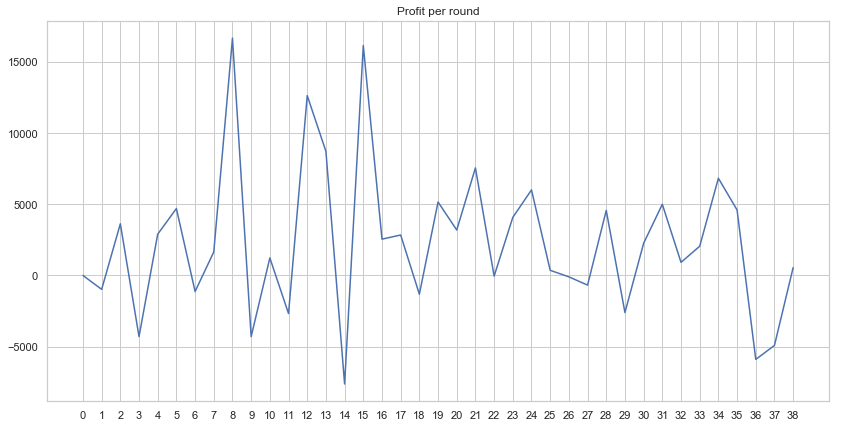

In [198]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Profit per round')
plt.plot(profitflow)
ax.set_xticks(range(0,39));

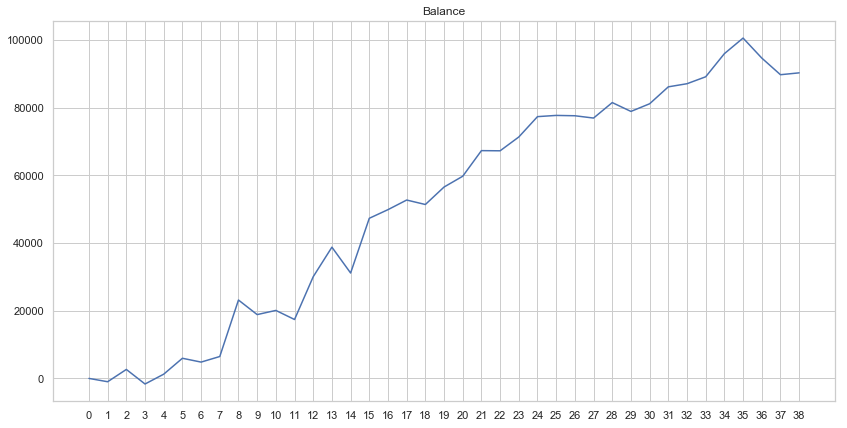

In [135]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Balance')
plt.plot(moneyflow)
ax.set_xticks(range(0,39));

In [136]:
bettinggame

,League,Season,Match_Date,H Team,A Team,odds_w,odds_d,odds_l,Predict,Result,Match?,Round,kelly score,betting rate
0,SERIE,1718,170820,Atalanta,Roma,3.20,3.30,2.30,H,A,X,1,0.447273,0.271763
1,EPL,1718,170812,West Bromwich Albion,Bournemouth,2.40,3.30,3.30,H,H,O,1,0.348571,0.211792
2,SERIE,1718,170820,Udinese,Chievo,2.10,3.20,3.80,H,A,X,1,0.274545,0.166814
3,SERIE,1718,170820,Bologna,Torino,3.10,3.30,2.38,A,D,X,1,0.258406,0.157008
4,EPL,1718,170812,Crystal Palace,Huddersfield,1.83,3.60,5.00,H,A,X,1,0.162169,0.098534
5,EPL,1718,170812,Everton,Stoke,1.70,3.80,5.75,H,H,O,1,0.077143,0.046872
6,SERIE,1718,170820,Sampdoria,Benevento,1.67,3.75,5.50,H,H,O,1,0.052836,0.032103
7,SERIE,1718,170820,Sassuolo,Genoa,2.20,3.25,3.50,D,D,O,1,0.017778,0.010802
8,EPL,1718,170812,Southampton,Swansea,1.62,4.00,6.50,H,D,X,1,0.007097,0.004312
9,SERIE,1718,170826,Roma,Inter,2.30,3.50,3.00,A,A,O,2,0.355000,0.185511


In [203]:
bettinggame

,League,Season,Match_Date,H Team,A Team,odds_w,odds_d,odds_l,Predict,Result,Match?,Round,kelly score,betting rate
0,SERIE,1718,170820,Atalanta,Roma,3.20,3.30,2.30,H,A,X,1,0.447273,0.271763
1,EPL,1718,170812,West Bromwich Albion,Bournemouth,2.40,3.30,3.30,H,H,O,1,0.348571,0.211792
2,SERIE,1718,170820,Udinese,Chievo,2.10,3.20,3.80,H,A,X,1,0.274545,0.166814
3,SERIE,1718,170820,Bologna,Torino,3.10,3.30,2.38,A,D,X,1,0.258406,0.157008
4,EPL,1718,170812,Crystal Palace,Huddersfield,1.83,3.60,5.00,H,A,X,1,0.162169,0.098534
5,EPL,1718,170812,Everton,Stoke,1.70,3.80,5.75,H,H,O,1,0.077143,0.046872
6,SERIE,1718,170820,Sampdoria,Benevento,1.67,3.75,5.50,H,H,O,1,0.052836,0.032103
7,SERIE,1718,170820,Sassuolo,Genoa,2.20,3.25,3.50,D,D,O,1,0.017778,0.010802
8,EPL,1718,170812,Southampton,Swansea,1.62,4.00,6.50,H,D,X,1,0.007097,0.004312
9,SERIE,1718,170826,Roma,Inter,2.30,3.50,3.00,A,A,O,2,0.355000,0.185511


In [201]:
#라운드 별 10000원씩 켈리값 높은 10개 순서대로

profitperround = {}
for i in range(1,39):
    profitperround[i] = 0

seedmoney = 0
totalprofit = 0
profitflow = [0]
moneyflow = [0]
accumulated_profit = [0]
for r in rounds:
    roundmatch = bettinggame[(bettinggame['Round']==r)]
    roundmatch = roundmatch.reset_index(drop=True)
    roundprofit = 0
    for idx, (i, predic) in enumerate(zip(roundmatch['betting rate'], roundmatch['Predict'])):
        if roundmatch.loc[idx, 'Match?'] == 'O':
            if predic == 'H':
                profit = roundmatch.loc[idx,'odds_w']*10000*roundmatch.loc[idx,'betting rate']
            elif predic == 'D':
                profit = roundmatch.loc[idx,'odds_d']*10000*roundmatch.loc[idx,'betting rate']
            else:
                profit = roundmatch.loc[idx,'odds_l']*10000*roundmatch.loc[idx,'betting rate']
            roundprofit += profit 
    profitperround[r] = roundprofit 
    totalprofit += roundprofit 
    profitflow.append(roundprofit-10000)
    seedmoney += roundprofit-10000
    moneyflow.append(seedmoney)
    accumulated_profit.append(accumulated_profit[-1]+roundprofit)

In [202]:
temp = ((totalprofit/380000) - 1) * 100
print('수익률 : {:4f} %'.format(temp))

수익률 : 10.496321 %


In [151]:
totalprofit

419886.01844425045

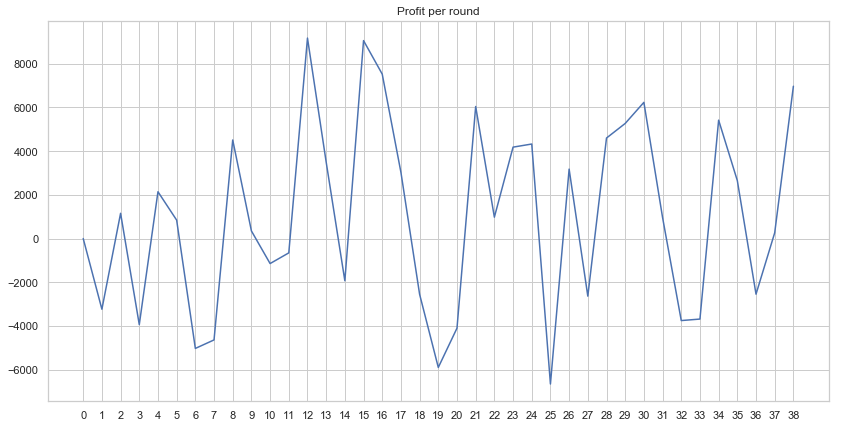

In [152]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Profit per round')
plt.plot(profitflow)
ax.set_xticks(range(0,39));

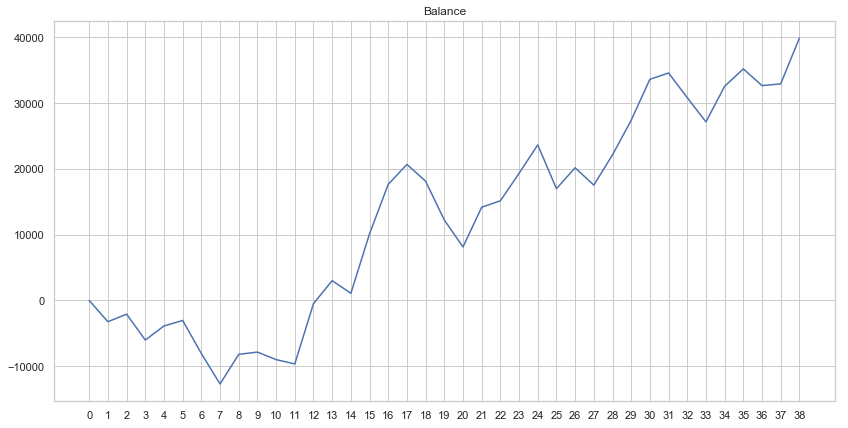

In [153]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Balance')
plt.plot(moneyflow)
ax.set_xticks(range(0,39));

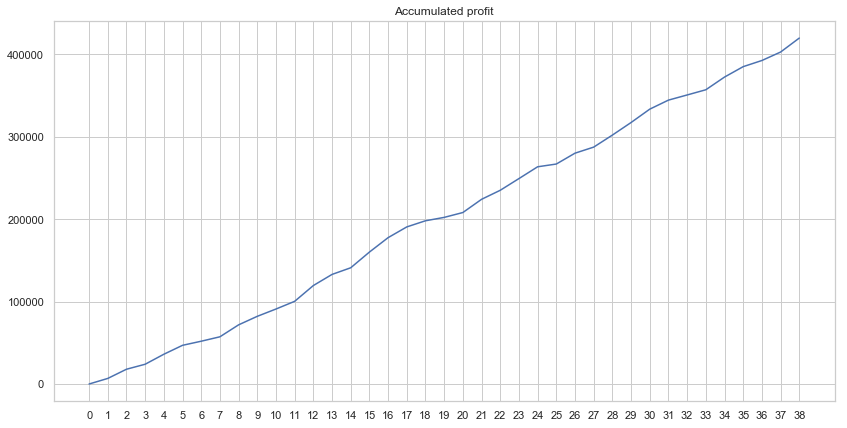

In [154]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Accumulated profit')
plt.plot(accumulated_profit)
ax.set_xticks(range(0,39));

In [216]:
1 + roundmatch.loc[3,'kelly score']

1.1621686746987951

In [57]:
#켈리값에 그대로 베팅한 경우

profitperround = {}
for i in range(1,39):
    profitperround[i] = 0

seedmoney = 0
totalprofit = 0
profitflow = [0]
moneyflow = [0]
accumulated_profit = [0]
totalbettingmoney = 0
numofbettinggame = 0
for r in rounds:
    totalkellyscore = 0
    roundmatch = bettinggame[(bettinggame['Round']==r)]
    roundmatch = roundmatch.reset_index(drop=True)
    roundprofit = 0
    bettingmoney = 0
    for idx, (i, predic) in enumerate(zip(roundmatch['betting rate'], roundmatch['Predict'])):
        #bettingmoney = i * seedmoney
        #seedmoney -= bettingmoney
        
        if roundmatch.loc[idx, 'Match?'] == 'O' and (totalkellyscore + roundmatch.loc[idx,'kelly score']) < 1:
            if predic == 'H':
                profit = roundmatch.loc[idx,'odds_w']*10000*roundmatch.loc[idx,'kelly score']
                bettingmoney += 10000*roundmatch.loc[idx,'kelly score']
                totalkellyscore += roundmatch.loc[idx,'kelly score']
                numofbettinggame += 1
            elif predic == 'D':
                profit = roundmatch.loc[idx,'odds_d']*10000*roundmatch.loc[idx,'kelly score']
                bettingmoney += 10000*roundmatch.loc[idx,'kelly score']
                totalkellyscore += roundmatch.loc[idx,'kelly score']
                numofbettinggame += 1
            else:
                profit = roundmatch.loc[idx,'odds_l']*10000*roundmatch.loc[idx,'kelly score']
                bettingmoney += 10000*roundmatch.loc[idx,'kelly score']
                totalkellyscore += roundmatch.loc[idx,'kelly score']
                numofbettinggame += 1
            roundprofit += profit 
        elif roundmatch.loc[idx, 'Match?'] == 'X' and (totalkellyscore + roundmatch.loc[idx,'kelly score']) < 1:
            if predic == 'H':
                bettingmoney += 10000*roundmatch.loc[idx,'kelly score']
                totalkellyscore += roundmatch.loc[idx,'kelly score']
                numofbettinggame += 1
            elif predic == 'D':
                bettingmoney += 10000*roundmatch.loc[idx,'kelly score']
                totalkellyscore += roundmatch.loc[idx,'kelly score']
                numofbettinggame += 1
            else:
                bettingmoney += 10000*roundmatch.loc[idx,'kelly score']
                totalkellyscore += roundmatch.loc[idx,'kelly score']
                numofbettinggame += 1
                
    totalbettingmoney += bettingmoney
    profitperround[r] = roundprofit 
    totalprofit += roundprofit 
    profitflow.append(roundprofit-bettingmoney)
    seedmoney += roundprofit-bettingmoney
    moneyflow.append(seedmoney)
    accumulated_profit.append(accumulated_profit[-1]+roundprofit)

In [58]:
temp = ((totalprofit/totalbettingmoney) - 1) * 100
print('수익률 : {:4f} %'.format(temp))

수익률 : 16.433947 %


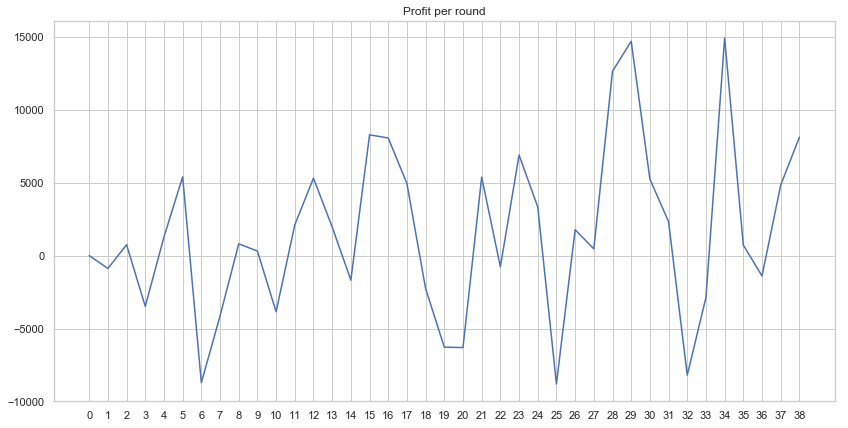

In [59]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Profit per round')
plt.plot(profitflow)
ax.set_xticks(range(0,39));

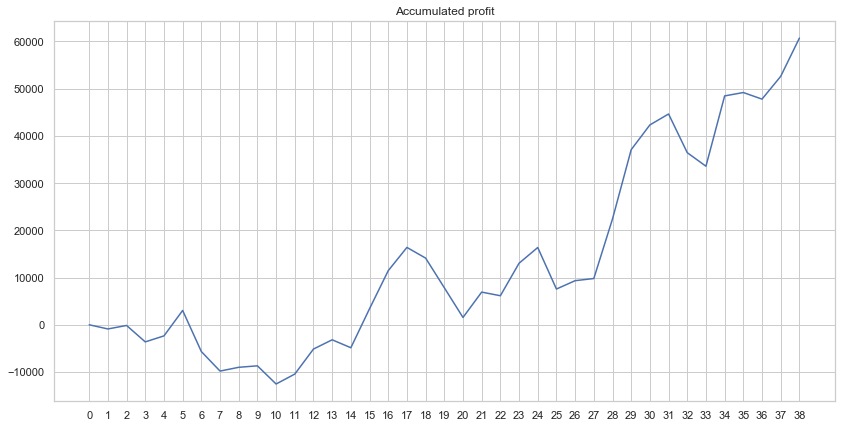

In [60]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Accumulated profit')
plt.plot(moneyflow)
ax.set_xticks(range(0,39));

In [66]:
#축적한 수익까지 합쳐서 베팅

profitperround = {}
for i in range(1,39):
    profitperround[i] = 0

seedmoney = 10000
totalprofit = 0
profitflow = [0]
moneyflow = [0]
totalbettingmoney = 0 
for r in rounds:
    roundmatch = bettinggame[(bettinggame['Round']==r)]
    roundmatch = roundmatch.reset_index(drop=True)
    roundprofit = 0
    bettingmoney = 0
    for idx, (i, predic) in enumerate(zip(roundmatch['betting rate'], roundmatch['Predict'])):
        bettingmoney += seedmoney*roundmatch.loc[idx,'betting rate']*0.6
        if roundmatch.loc[idx, 'Match?'] == 'O':
            if predic == 'H':
                profit = roundmatch.loc[idx,'odds_w']*seedmoney*roundmatch.loc[idx,'betting rate']*0.6
            elif predic == 'D':
                profit = roundmatch.loc[idx,'odds_d']*seedmoney*roundmatch.loc[idx,'betting rate']*0.6
            else:
                profit = roundmatch.loc[idx,'odds_l']*seedmoney*roundmatch.loc[idx,'betting rate']*0.6
            roundprofit += profit 
    
    profitperround[r] = roundprofit 
    totalprofit += roundprofit 
    profitflow.append(roundprofit-bettingmoney)
    seedmoney += roundprofit-bettingmoney
    moneyflow.append(seedmoney)
    totalbettingmoney += bettingmoney
    #print('배팅액 : {} 수익 : {} 순수익 : {} 잔고 : {}'.format(bettingmoney, roundprofit, (roundprofit-bettingmoney), seedmoney))

In [67]:
temp = ((totalprofit/totalbettingmoney) - 1) * 100
print('수익률 : {:4f} %'.format(temp))

수익률 : 7.603735 %


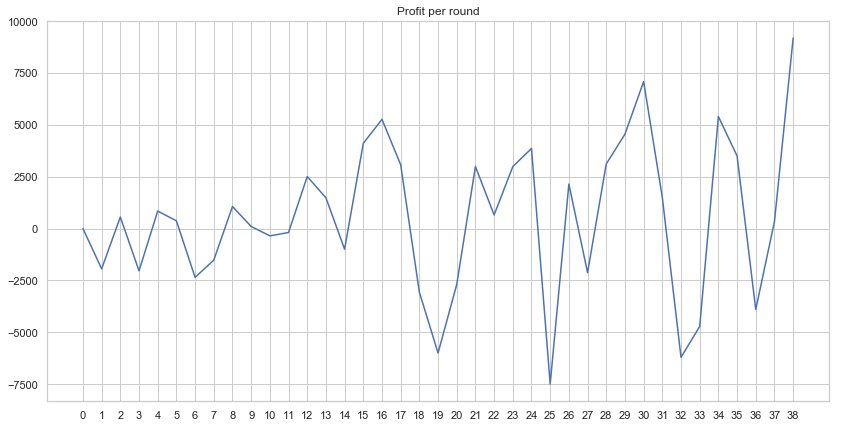

In [45]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Profit per round')
plt.plot(profitflow)
ax.set_xticks(range(0,39));

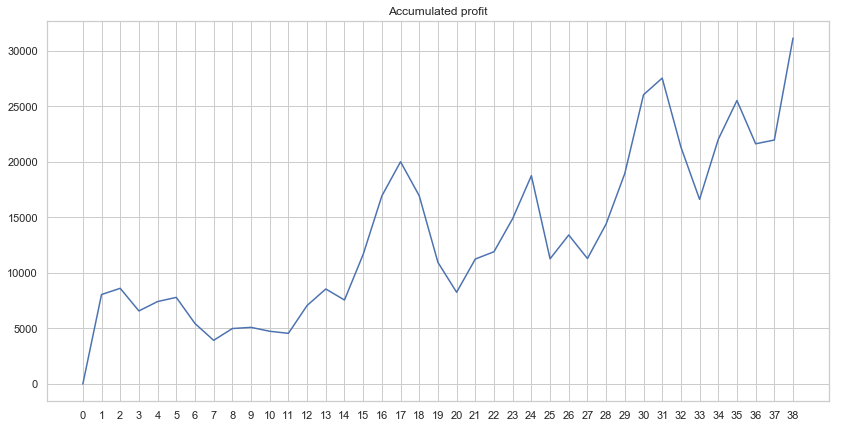

In [46]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Accumulated profit')
plt.plot(moneyflow)
ax.set_xticks(range(0,39));

In [69]:
def insertkelly(row):
    kelly_score = kelly(row['probs'], row['odds'])
    return kelly_score

In [70]:
import itertools
from tqdm import tqdm_notebook
for r in tqdm_notebook(rounds):
    if r == 1:
        betting_table = pd.DataFrame()
    
    match = []
    for date, h, a in zip(predictiondata['Match_Date'][predictiondata['Round']==r], 
                       predictiondata['H Team'][predictiondata['Round']==r],
                      predictiondata['A Team'][predictiondata['Round']==r]):
        match.append(str(date)+'-'+h+' vs '+a)
    match_combination = list(itertools.combinations(match,2))

    pol1, pol2 =[], []
    for i in match_combination:
        pol1.append(i[0])
        pol2.append(i[1])

    bettinggame = pd.DataFrame()
    bettinggame['Round'] = [r for i in range(len(match_combination))]
    bettinggame['match1'] = pol1
    bettinggame['match2'] = pol2

    odds_list = []
    prob_list = []
    kelly_list = []
    betwin = []
    for i in range(bettinggame.shape[0]):
        m1 = bettinggame.loc[i, 'match1']
        m1date = int(m1.split('-')[0])
        m1h = m1.split('-')[1].split(' vs ')[0]
        m1a = m1.split('-')[1].split(' vs ')[1]

        m2 = bettinggame.loc[i, 'match2']
        m2date = int(m2.split('-')[0])
        m2h = m2.split('-')[1].split(' vs ')[0]
        m2a = m2.split('-')[1].split(' vs ')[1]

        m1table = predictiondata[(predictiondata['Match_Date']==m1date)&(predictiondata['H Team']==m1h)].reset_index(drop=True)
        m2table = predictiondata[(predictiondata['Match_Date']==m2date)&(predictiondata['H Team']==m2h)].reset_index(drop=True)

        if m1table.loc[0,'Predict'] == 'H':m1odds, m1prob = float(m1table['odds_w']), 0.62
        elif m1table.loc[0,'Predict'] == 'A':m1odds, m1prob = float(m1table['odds_l']), 0.57
        else:m1odds, m1prob = float(m1table['odds_d']), 0.32

        if m2table.loc[0,'Predict'] == 'H':m2odds, m2prob = float(m2table['odds_w']), 0.62
        elif m2table.loc[0,'Predict'] == 'A':m2odds, m2prob = float(m2table['odds_l']), 0.57
        else:m2odds, m2prob = float(m2table['odds_d']), 0.32
        
        if (m1table.loc[0,'Match?'] == 'O') and m2table.loc[0,'Match?'] == 'O': betwin.append('O')
        else: betwin.append('X')
        
        odds = m1odds * m2odds
        odds_list.append(odds)
        prob = m1prob * m2prob
        prob_list.append(prob)

    bettinggame['odds'] = odds_list
    bettinggame['probs'] = prob_list
    bettinggame['k score'] = bettinggame.apply(lambda row: insertkelly(row), axis=1)
    bettinggame['Match?'] = betwin
    sorted_bet2pol = bettinggame.sort_values(by='k score', ascending=False)
    sorted_bet2pol = sorted_bet2pol.reset_index(drop=True)

    betting_list = []
    bet = []
    """
    for i in range(sorted_bet2pol.shape[0]):
        if (sorted_bet2pol.loc[i, 'match1'] not in betting_list) and (sorted_bet2pol.loc[i, 'match2'] not in betting_list):
            bet.append('O')
            betting_list.append(sorted_bet2pol.loc[i, 'match1'])
            betting_list.append(sorted_bet2pol.loc[i, 'match2'])
        else:
            bet.append('X')
    """
    #팀 중복 베팅
    for i in range(sorted_bet2pol.shape[0]):
        if i < 5:
            bet.append('O')
 
        else:
            bet.append('X')
           
    sorted_bet2pol['betting?'] = bet
    sorted_bet2pol = sorted_bet2pol[(sorted_bet2pol['betting?'] == 'O')&(sorted_bet2pol['k score'] > 0)]
    ksum = sorted_bet2pol['k score'].sum()
    sorted_bet2pol['bet rate'] = [i/ksum for i in sorted_bet2pol['k score']]
    sorted_bet2pol = sorted_bet2pol.iloc[:5,:]
    betting_table = pd.concat([betting_table, sorted_bet2pol], axis=0)
betting_table = betting_table.reset_index(drop=True)
del betting_table['betting?']

HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

In [85]:
Counter(betting_table['Match?'])

Counter({'O': 44, 'X': 146})

In [50]:
betting_table

,Round,match1,match2,odds,probs,k score,Match?,bet rate
0,1,170812-West Bromwich Albion vs Bournemouth,170820-Atalanta vs Roma,7.6800,0.3844,0.292244,X,0.220052
1,1,170820-Atalanta vs Roma,170820-Udinese vs Chievo,6.7200,0.3844,0.276778,X,0.208406
2,1,170812-Crystal Palace vs Huddersfield,170820-Atalanta vs Roma,5.8560,0.3844,0.257629,X,0.193988
3,1,170820-Atalanta vs Roma,170820-Bologna vs Torino,7.6160,0.3534,0.255667,X,0.192510
4,1,170812-Everton vs Stoke,170820-Atalanta vs Roma,5.4400,0.3844,0.245751,X,0.185044
5,2,170826-Roma vs Inter,170827-SPAL 2013 vs Udinese,8.7000,0.3249,0.237225,X,0.208501
6,2,170820-Tottenham vs Chelsea,170826-Roma vs Inter,6.3000,0.3534,0.231400,X,0.203382
7,2,170820-Tottenham vs Chelsea,170827-SPAL 2013 vs Udinese,6.0900,0.3534,0.226367,X,0.198958
8,2,170819-Bournemouth vs Watford,170826-Roma vs Inter,6.0000,0.3534,0.224080,X,0.196948
9,2,170819-Bournemouth vs Watford,170827-SPAL 2013 vs Udinese,5.8000,0.3534,0.218692,X,0.192212


In [72]:
#만원씩만 걸때
profitperround = {}
for i in range(1,39):
    profitperround[i] = 0

seedmoney = 0
totalprofit = 0
profitflow = [0]
moneyflow = [0]
totalbettingmoney = 0
accumulated_profit = [0]
for r in rounds:
    roundmatch = betting_table[(betting_table['Round']==r)]
    roundmatch = roundmatch.reset_index(drop=True)
    roundprofit = 0
    for idx, i in enumerate(roundmatch['Match?']):
        if i == 'O':
            profit = roundmatch.loc[idx, 'odds'] * roundmatch.loc[idx, 'bet rate'] * 10000
            roundprofit += profit 
        #else:
            #profit = roundmatch.loc[idx, 'bet rate'] * 10000
            #roundprofit -= profit 
    profitperround[r] = roundprofit 
    totalprofit += roundprofit 
    totalbettingmoney += 10000
    profitflow.append(roundprofit-10000)
    seedmoney += roundprofit-10000
    moneyflow.append(seedmoney)
    accumulated_profit.append(accumulated_profit[-1]+roundprofit)

In [73]:
temp = ((totalprofit/totalbettingmoney) - 1) * 100
print('수익률 : {:4f} %'.format(temp))

수익률 : 13.733836 %


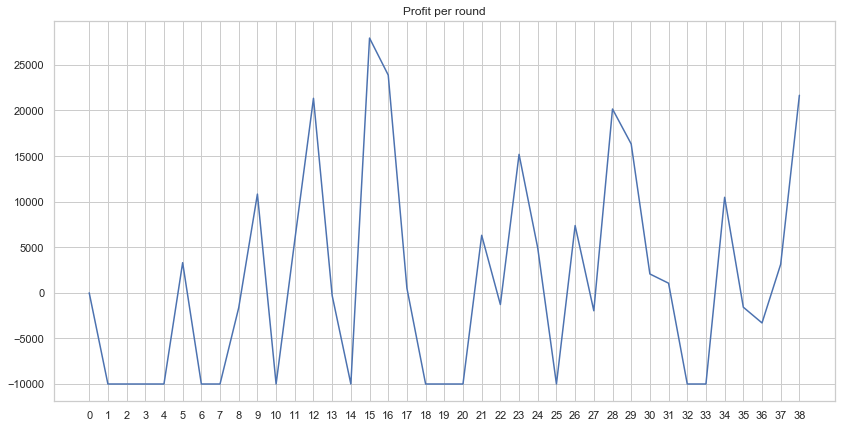

In [74]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Profit per round')
plt.plot(profitflow)
ax.set_xticks(range(0,39));

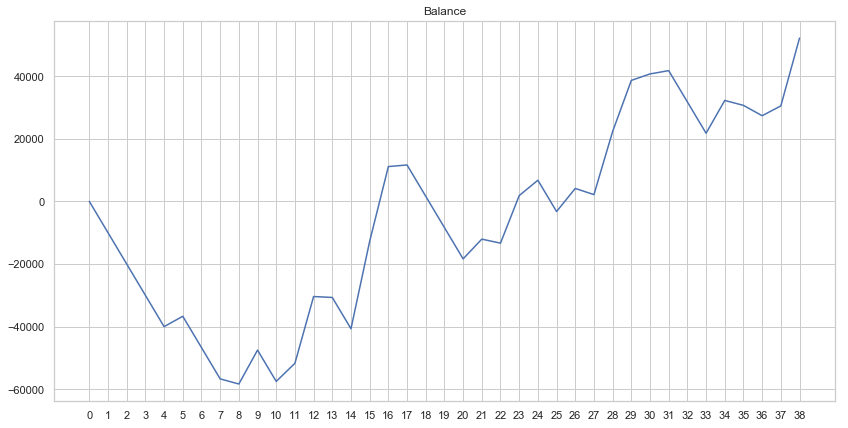

In [75]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Balance')
plt.plot(moneyflow)
ax.set_xticks(range(0,39));

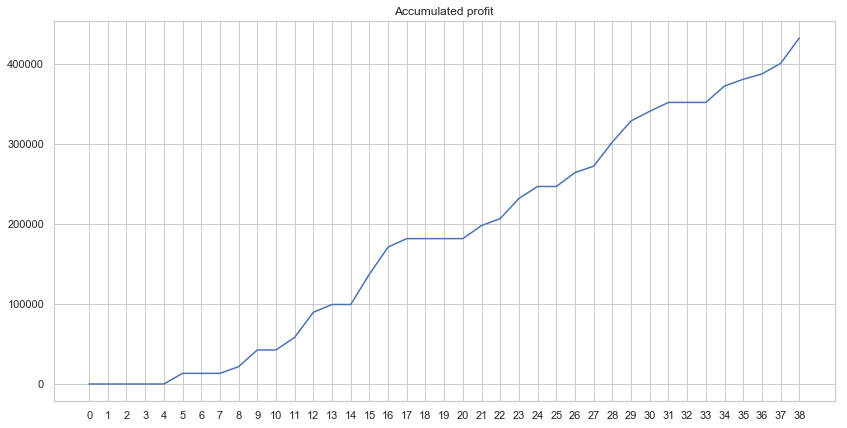

In [76]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Accumulated profit')
plt.plot(accumulated_profit)
ax.set_xticks(range(0,39));

In [77]:
#만원씩만 20%씩 걸때
profitperround = {}
for i in range(1,39):
    profitperround[i] = 0

seedmoney = 0
totalprofit = 0
profitflow = [0]
moneyflow = [0]
totalbettingmoney = 0
accumulated_profit = [0]
for r in rounds:
    roundmatch = betting_table[(betting_table['Round']==r)]
    roundmatch = roundmatch.reset_index(drop=True)
    roundprofit = 0
    for idx, i in enumerate(roundmatch['Match?']):
        if i == 'O':
            profit = roundmatch.loc[idx, 'odds'] * 0.2 * 10000
            roundprofit += profit 
        #else:
            #profit = roundmatch.loc[idx, 'bet rate'] * 10000
            #roundprofit -= profit 
    profitperround[r] = roundprofit 
    totalprofit += roundprofit 
    totalbettingmoney += 10000
    profitflow.append(roundprofit-10000)
    seedmoney += roundprofit-10000
    moneyflow.append(seedmoney)
    accumulated_profit.append(accumulated_profit[-1]+roundprofit)

In [78]:
temp = ((totalprofit/totalbettingmoney) - 1) * 100
print('수익률 : {:4f} %'.format(temp))

수익률 : 13.929158 %


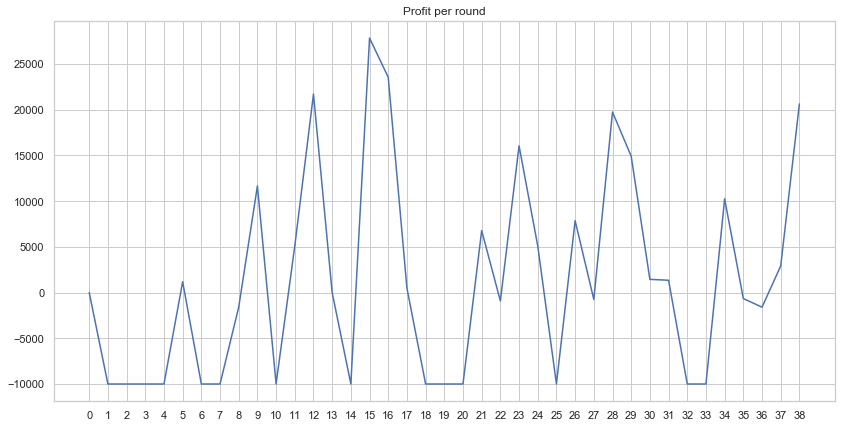

In [79]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Profit per round')
plt.plot(profitflow)
ax.set_xticks(range(0,39));

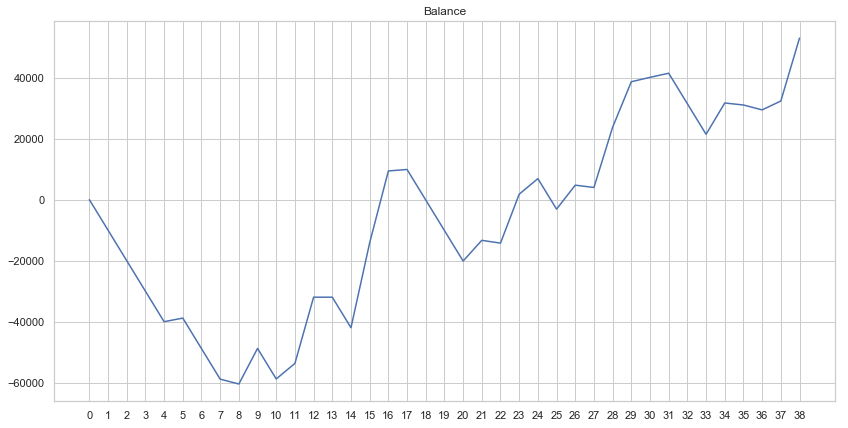

In [80]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Balance')
plt.plot(moneyflow)
ax.set_xticks(range(0,39));

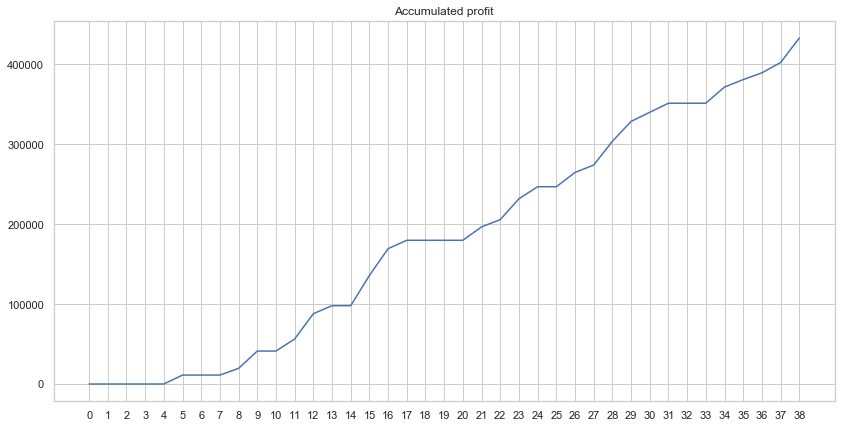

In [81]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Accumulated profit')
plt.plot(accumulated_profit)
ax.set_xticks(range(0,39));

In [89]:
#만원씩 똑같은 비율로 걸때
profitperround = {}
for i in range(1,39):
    profitperround[i] = 0

seedmoney = 0
totalprofit = 0
profitflow = [0]
moneyflow = [0]
totalbettingmoney = 0
accumulated_profit =[0]
for r in rounds:
    roundmatch = betting_table[(betting_table['Round']==r)]
    roundmatch = roundmatch.reset_index(drop=True)
    roundprofit = 0
    for idx, i in enumerate(roundmatch['Match?']):
        if i == 'O':
            profit = roundmatch.loc[idx, 'odds'] * 0.2 * 10000
            roundprofit += profit 
        #else:
            #profit = roundmatch.loc[idx, 'bet rate'] * 10000
            #roundprofit -= profit 
    profitperround[r] = roundprofit 
    totalprofit += roundprofit 
    totalbettingmoney += 10000
    profitflow.append(roundprofit-10000)
    seedmoney += roundprofit-10000
    moneyflow.append(seedmoney)
    accumulated_profit.append(accumulated_profit[-1]+roundprofit)

In [90]:
temp = ((totalprofit/totalbettingmoney) - 1) * 100
print('수익률 : {:4f} %'.format(temp))

수익률 : 11.739684 %


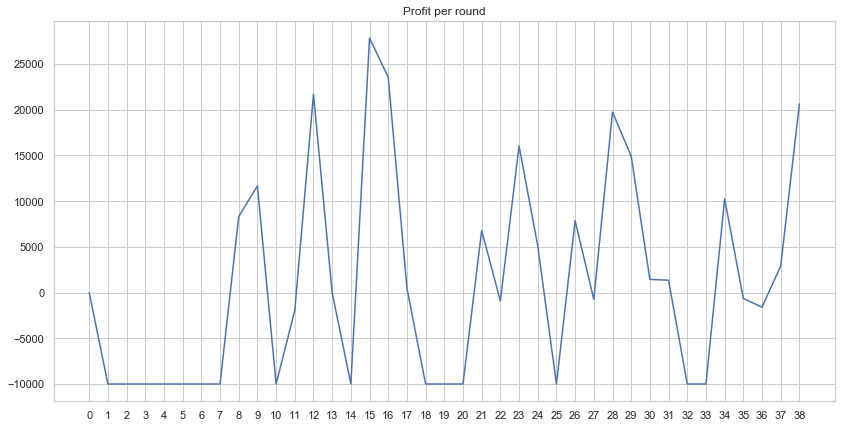

In [91]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Profit per round')
plt.plot(profitflow)
ax.set_xticks(range(0,39));

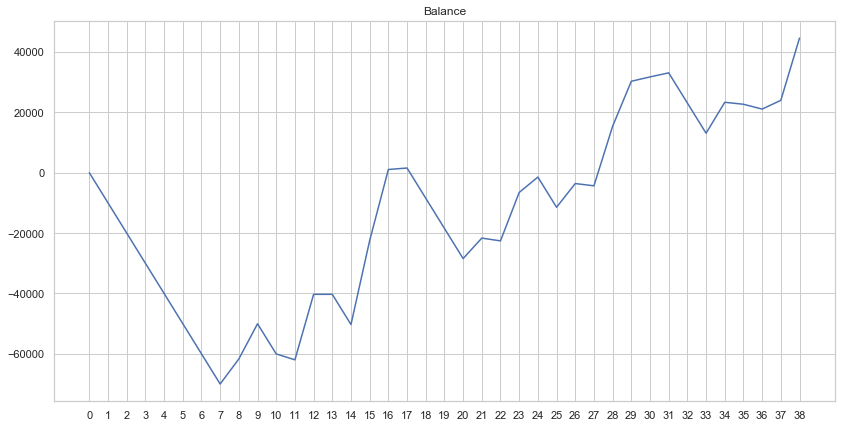

In [92]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Balance')
plt.plot(moneyflow)
ax.set_xticks(range(0,39));

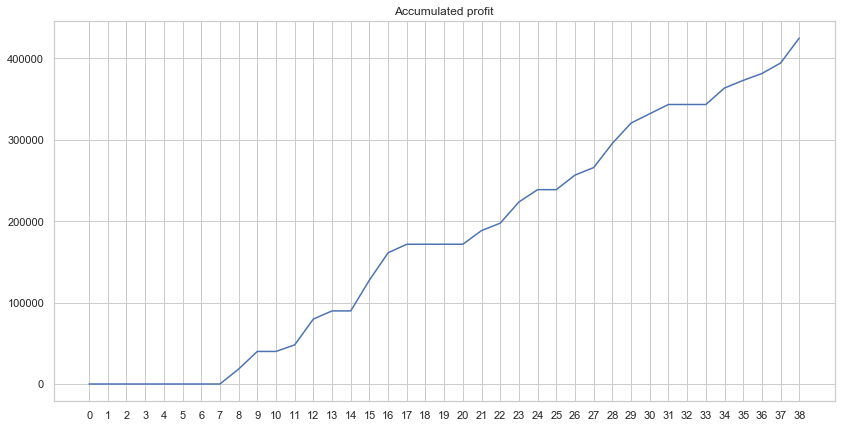

In [93]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Accumulated profit')
plt.plot(accumulated_profit)
ax.set_xticks(range(0,39));

In [104]:
profitperround = {}
for i in range(1,39):
    profitperround[i] = 0

seedmoney = 100000
totalprofit = 0
profitflow = [0]
moneyflow = [seedmoney]
bettingflow = [0]
totalbettingmoney = 0
accumulated_profit =[0]
for r in rounds:
    roundmatch = betting_table[(betting_table['Round']==r)]
    roundmatch = roundmatch.reset_index(drop=True)
    roundprofit = 0
    for idx, i in enumerate(roundmatch['Match?']):
        if seedmoney > 50000:
            betmoney = 50000
        else:
            betmoney = seedmoney
        if i == 'O':
            profit = roundmatch.loc[idx, 'odds'] * roundmatch.loc[idx, 'bet rate'] * betmoney * 0.6
            roundprofit += profit 
        #else:
            #profit = roundmatch.loc[idx, 'bet rate'] * 10000
            #roundprofit -= profit 
    bettingflow.append(betmoney*0.6)
    profitperround[r] = roundprofit 
    totalprofit += roundprofit 
    totalbettingmoney += betmoney * 0.6
    profitflow.append(roundprofit-betmoney * 0.6)
    seedmoney += roundprofit-betmoney*0.6
    moneyflow.append(seedmoney)
    accumulated_profit.append(accumulated_profit[-1]+roundprofit)

In [105]:
totalbettingmoney

110507.26616469078

In [106]:
temp = ((totalprofit/totalbettingmoney) - 1) * 100
print('수익률 : {:4f} %'.format(temp))

수익률 : -89.955176 %


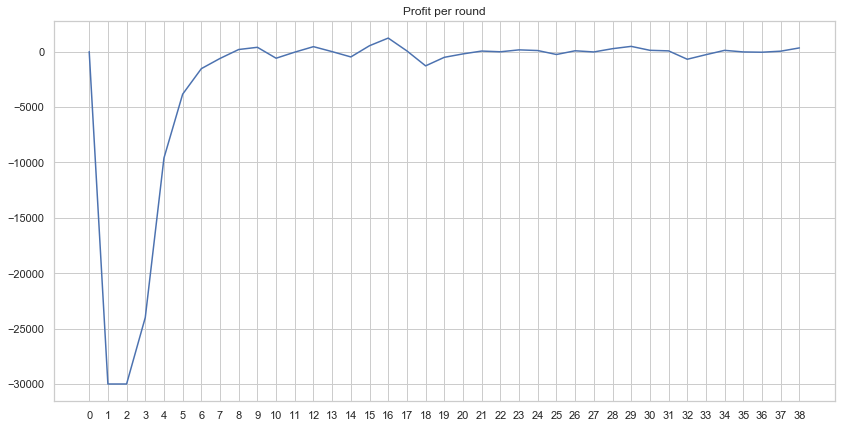

In [109]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Profit per round')
plt.plot(profitflow)
ax.set_xticks(range(0,39));

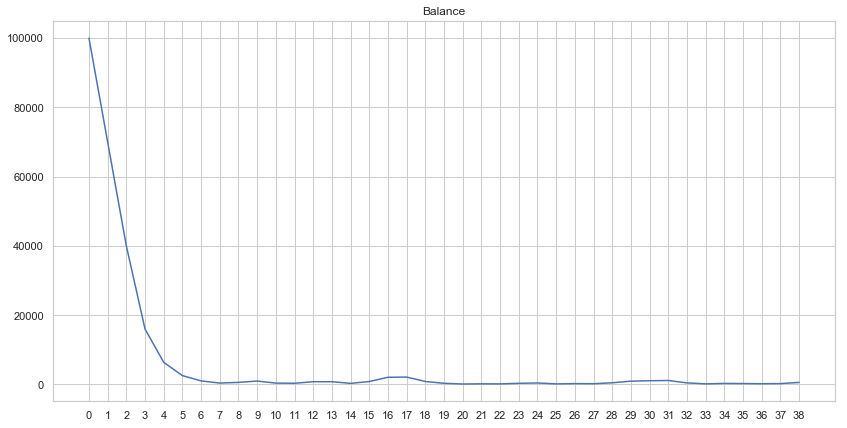

In [110]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Balance')
plt.plot(moneyflow)
ax.set_xticks(range(0,39));

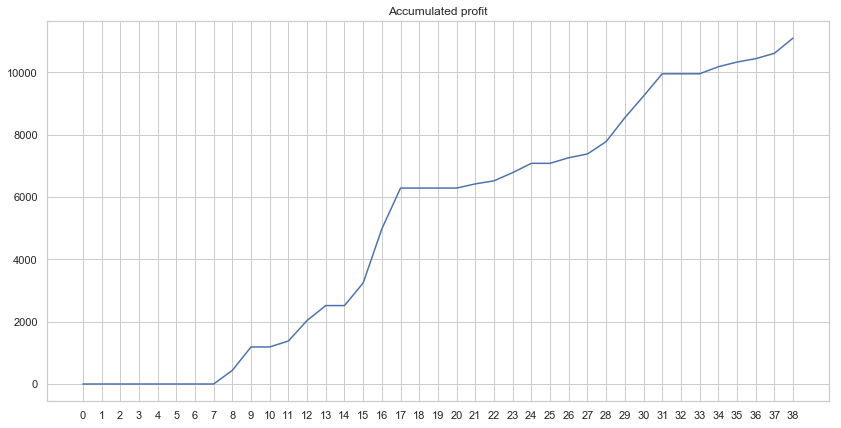

In [111]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Accumulated profit')
plt.plot(accumulated_profit)
ax.set_xticks(range(0,39));

In [160]:
predictiondata

,League,Season,Match_Date,H Team,A Team,odds_w,odds_d,odds_l,Predict,Result,Match?
0,EPL,1718,170811,Arsenal,Leicester,1.53,4.50,6.50,H,H,O
1,EPL,1718,170812,Watford,Liverpool,6.00,4.20,1.62,A,D,X
2,EPL,1718,170812,West Bromwich Albion,Bournemouth,2.40,3.30,3.30,H,H,O
3,EPL,1718,170812,Southampton,Swansea,1.62,4.00,6.50,H,D,X
4,EPL,1718,170812,Chelsea,Burnley,1.25,6.50,15.00,H,A,X
5,EPL,1718,170812,Crystal Palace,Huddersfield,1.83,3.60,5.00,H,A,X
6,EPL,1718,170812,Everton,Stoke,1.70,3.80,5.75,H,H,O
7,EPL,1718,170812,Brighton,Manchester City,11.00,5.50,1.33,A,A,O
8,EPL,1718,170813,Newcastle United,Tottenham,5.50,4.00,1.70,A,A,O
9,EPL,1718,170813,Manchester United,West Ham,1.30,5.75,12.00,H,H,O
